# Overview
In this assignment you will implement part of the framework for closed-loop neural control as discussed in the lecture, and reproduce some of the key results. The assignment is structured in three parts, corresponding to the three components of the brain-machine-environment interaction.

In [1]:
from typing import Tuple, Callable

import numpy as np
from mxnet.ndarray import NDArray
from numpy.linalg import inv
from scipy.linalg import solve_discrete_are
import mxnet as mx
from mxnet import autograd
import matplotlib.pyplot as plt
from tqdm import trange

## Helper code
The code below does not contain anything concptually new; it re-implements some of the functions you have worked with in previous assignments, such as recurrent neural networks (RNNs), linear quadratic regularizer (LQR), functions to run the double integrator system, and visualization tools. Feel free to use your own code if it is more convenient.

In [2]:
class RNN(mx.gluon.Block):
    """Single-layer vanilla RNN with fully-connected decoder."""
    def __init__(self, num_hidden=1, num_outputs=1, num_inputs=1,
                 activation_rnn=None, activation_decoder=None, **kwargs):

        super().__init__(**kwargs)

        # The mxnet RNN class does not support linear activations, so we
        # implement it using a LeakyReLU with slope 1.
        if activation_rnn == 'linear':
            activation_rnn = mx.gluon.nn.LeakyReLU(1)
        with self.name_scope():
            self.rnn = mx.gluon.rnn.RNNCell(num_hidden,
                                            activation_rnn,
                                            input_size=num_inputs,
                                            prefix='rnn_')
            self.decoder = mx.gluon.nn.Dense(num_outputs,
                                             activation_decoder,
                                             in_units=num_hidden,
                                             prefix='decoder_')
        self.initialize()

    def forward(self, inputs: NDArray, states: NDArray) \
            -> Tuple[NDArray, NDArray]:
        """Perform forward pass of model."""

        # Add a dummy batch dimension of size 1.
        inputs = mx.nd.expand_dims(inputs, 0)
        states = mx.nd.expand_dims(states, 0)

        # Perform forward pass.
        states, _ = self.rnn(inputs, [states])
        outputs = self.decoder(states)

        # Remove dummy dimensions
        return outputs[0], states[0]

    def forward_np(self, inputs: np.ndarray, states: np.ndarray) \
            -> Tuple[np.ndarray, np.ndarray]:
        """Perform forward pass on numpy arrays. Only use during inference."""
        outputs, states = self.forward(mx.nd.array(inputs),
                                       mx.nd.array(states))
        return outputs.asnumpy(), states.asnumpy()

    def freeze_weights(self):
        """Prevent weights of system to adapt."""
        self.collect_params().setattr('grad_req', 'null')

    def get_state_init(self, asnumpy=False):
        """Return the initial states.

        Parameters
        ----------
        asnumpy
            Whether to return as numpy or mxnet array.
        Returns
        -------
            Initial states of system (all zero).
        """
        x = self.rnn.begin_state(1)[0][0]
        if asnumpy:
            return x.asnumpy()
        return x

    @property
    def A(self):
        """Dynamics matrix."""
        return self.rnn.h2h_weight.data().asnumpy()

    @A.setter
    def A(self, a):
        self.rnn.h2h_weight.data()[:] = a

    @property
    def B(self):
        """Input matrix."""
        return self.rnn.i2h_weight.data().asnumpy()

    @B.setter
    def B(self, b):
        self.rnn.i2h_weight.data()[:] = b

    @property
    def C(self):
        """Output matrix."""
        return self.decoder.weight.data().asnumpy()

    @C.setter
    def C(self, c):
        self.decoder.weight.data()[:] = c


class LQR:
    """A helper class to compute cost and control of LQR solution."""
    def __init__(self, environment: RNN, dt: float, q=0.5, r=0.5):
        self.A = environment.A
        self.B = environment.B
        self.Q = np.eye(len(self.A)) * q * dt
        self.R = np.eye(len(self.B.T)) * r * dt
        self.K = self.get_gain()

    def get_cost(self, x: np.ndarray, u: np.ndarray) -> np.ndarray:
        return x.T @ self.Q @ x + u.T @ self.R @ u

    def get_gain(self):
        # Solution to the DARE
        S = solve_discrete_are(self.A, self.B, self.Q, self.R)

        # Feedback gain matrix
        return (np.linalg.inv(self.B.T @ S @ self.B + self.R) @
                self.B.T @ S @ self.A)

    def get_control(self, x):
        return -self.K @ x


class LqrMx:
    """A helper class to compute the LQR loss as mxnet array."""
    def __init__(self, lqr: LQR):
        self.Q = mx.nd.array(lqr.Q)
        self.R = mx.nd.array(lqr.R)

    def get_cost(self, x: NDArray, u: NDArray) -> NDArray:
        return (mx.nd.dot(mx.nd.dot(x, self.Q), x) +
                mx.nd.dot(mx.nd.dot(u, self.R), u))


def evaluate_uncontrolled(
        num_steps: int,
        x_init: Tuple[float, float],
        environment: RNN,
        objective_function: Callable[[np.ndarray, np.ndarray], np.ndarray]) \
        -> Tuple[np.ndarray, np.ndarray]:
    """Test performance of system when no control is applied.

    Parameters
    ----------
    num_steps
        How many steps to take in environment during one episode.
    x_init
        Initial states of environment.
    environment
        The environment to be controlled.
    objective_function
        The LQR cost function used as evaluation metric.

    Returns
    -------
        Two arrays containing (for each time step):
            - Environment states
            - Costs
    """
    states = []
    costs = []

    x_environment = np.array(x_init)  # Initial state

    for n in range(num_steps):
        # Compute control.
        u_environment = np.zeros(1)

        # Compute lqr cost.
        cost = objective_function(x_environment, u_environment)

        # Take a step in environment.
        y_environment, x_environment = environment.forward_np(u_environment,
                                                              x_environment)

        states.append(x_environment)
        costs.append(cost)

    return np.array(states), np.array(costs)


def plot_variables(variables: dict, title: str):
    for label, variable in variables.items():
        plt.plot(variable, label=label)
    plt.axhline(0, color='k', linestyle='--')
    plt.title(title)
    plt.xlabel('Time step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


def plot_metrics(metrics: dict):
    for label, metric in metrics.items():
        plt.plot(metric, label=label)
    plt.axhline(0, color='k', linestyle='--')
    plt.xlabel('Time step')
    plt.ylabel('LQR cost')
    plt.legend()
    plt.show()


def plot_training_curve(loss: np.ndarray, title: str):
    plt.plot(loss)
    plt.axhline(0, color='k', linestyle='--')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()


def get_grid(n=10, x_max=1, y_max=0.2) -> NDArray:
    """Create a rectangular 2d grid.

    Parameters
    ----------
    n
        Number of grid nodes along each dimension.
    x_max
        Half the width of the grid (centered around zero).
    y_max
        Half the height of the grid (centered around zero).
    """

    x_min, x_max = -x_max, x_max
    y_min, y_max = -y_max, y_max
    grid = np.mgrid[y_min:y_max:complex(0, n), x_min:x_max:complex(0, n)]
    grid = grid[::-1]
    grid = np.reshape(grid, (-1, n * n))
    grid = np.transpose(grid)
    return mx.nd.array(grid)


def train_neuralsystem(
        num_steps: int,
        x_init: np.ndarray,
        environment: RNN,
        neuralsystem: RNN,
        objective_function: Callable[[NDArray, NDArray], NDArray]) \
        -> np.ndarray:
    """Train the neural system by minimizing an objective function.

    Parameters
    ----------
    num_steps
        How many steps to take in environment during one episode.
    x_init
        Initial states of environment. Shape [num_samples, num_states].
    environment
        The environment to control.
    neuralsystem
        The controller to train.
    objective_function
        The loss function to optimize. Must be compatible with mxnet arrays.

    Returns
    -------
        1D array with average loss values for each epoch.
    """
    learning_rate = 1e-3
    num_epochs = 5
    trainer = mx.gluon.Trainer(neuralsystem.collect_params(), 'adam',
                               {'learning_rate': learning_rate})
    loss_training = []
    for _ in trange(num_epochs, desc='epoch'):
        loss_epoch = []
        for x_environment in x_init:
            x_neuralsystem = neuralsystem.get_state_init()
            y_environment = x_environment
            loss_sample = []
            with autograd.record():
                for n in range(num_steps):
                    # Compute control.
                    y_neuralsystem, x_neuralsystem = neuralsystem.forward(
                        y_environment, x_neuralsystem)

                    # Compute lqr cost.
                    loss_sample.append(objective_function(x_environment,
                                                          y_neuralsystem))

                    # Take a step in environment.
                    y_environment, x_environment = environment.forward(
                        y_neuralsystem, x_environment)

                loss_sample_mean = mx.nd.mean(mx.nd.concat(*loss_sample,
                                                           dim=0))
            loss_sample_mean.backward()
            trainer.step(1)
            loss_epoch.append(loss_sample_mean.asscalar())

        loss_training.append(np.mean(loss_epoch))

    return np.array(loss_training)


## 1. Environment (2 points)
Here we create an environment for the agent (brain) to live in. We choose the double integrator dynamical system as environment (you may assume the noise-free and fully-observed case throughout this week's assignments). We want to be able to differentiate through the environment. You already implemented a differentiable version of the double integrator in assignment 8 using jax. Here we suggest to use the mxnet implementation provided above to simplify training the neural system and prosthesis later. So:
- **Create the double integrator environment as a recurrent neural network**. (Hint: The weights do not have to be learned but can be set directly using the state equations.)
- **Create an LQR controller** to solve the particle stabilization in the RNN environment. **Verify that the dynamics of the closed system match** the ones you found in assignment 6. Compare against the uncontrolled case. (Hint: Create a new function "evaluate_optimal" based on the "evaluate_uncontrolled" function above to get the dynamics of the closed system.)

### Setup

In [3]:
num_inputs_environment = 1  # Control input.
num_states_environment = 2  # Position and velocity.
num_outputs_environment = 2  # Full state observations.

environment = RNN(num_inputs=num_inputs_environment,
                  num_hidden=num_states_environment,
                  num_outputs=num_outputs_environment,
                  activation_rnn='linear', activation_decoder=None)

dt = 0.1
environment.A = np.array([[1, dt], [0, 1]])
environment.B = np.array([[0], [dt]])  # Control only second state.
environment.C = np.eye(num_outputs_environment, num_states_environment)


### Evaluation

In [4]:
def evaluate_optimal(
        num_steps: int,
        x_init: Tuple[float, float],
        environment: RNN,
        controller,
        objective_function: Callable[[np.ndarray, np.ndarray], np.ndarray]) \
        -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Test performance of LQR controller.

    Parameters
    ----------
    num_steps
        How many steps to take in environment during one episode.
    x_init
        Initial states of environment.
    environment
        The environment to be controlled.
    controller
        The LQR controller.
    objective_function
        The LQR cost function used as evaluation metric.

    Returns
    -------
        Three arrays containing (for each time step):
            - Environment states
            - Environment input (controls)
            - Costs
    """
    states = []
    controls = []
    costs = []

    x_environment = np.array(x_init)  # Initial state

    for n in range(num_steps):
        # Compute control.
        u_environment = controller.get_control(x_environment)

        # Compute lqr cost.
        cost = objective_function(x_environment, u_environment)

        # Take a step in environment.
        y_environment, x_environment = environment.forward_np(u_environment,
                                                              x_environment)

        states.append(x_environment)
        controls.append(u_environment)
        costs.append(cost)

    return np.array(states), np.array(controls), np.array(costs)


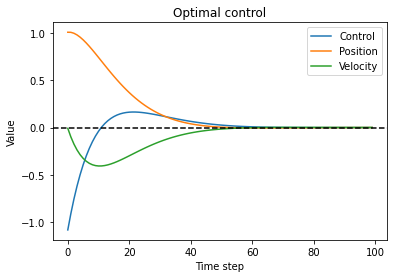

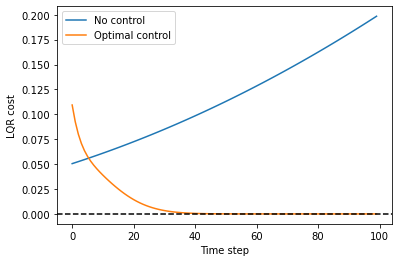

In [5]:
# How long to run the system during one episode.
num_steps = 100

# Initial state of environment for one episode (position and velocity).
x_environment_init = (1, 0.1)

# Create optimal LQR controller.
lqr = LQR(environment, dt)

# Define cost function to evaluate performance.
objective_function = lqr.get_cost

# Test uncontrolled case.
states_uncontrolled, costs_uncontrolled = evaluate_uncontrolled(
    num_steps, x_environment_init, environment, objective_function)

# Test optimal control.
states_optimal, controls_optimal, costs_optimal = evaluate_optimal(
    num_steps, x_environment_init, environment, lqr, objective_function)

# Show results.
plot_variables({'Control': controls_optimal,
                'Position': states_optimal[:, 0],
                'Velocity': states_optimal[:, 1]},
               'Optimal control')

plot_metrics({'No control': costs_uncontrolled,
              'Optimal control': costs_optimal})


## 2. Neural system (4 points)
Now we add a brain to interact with the environment. The brain replaces the optimal LQR controller above to perform the particle stabilization task.
- **Implement the neural system as an RNN**. (Hint: Use about 30-50 neurons for the hidden layer. The other dimensions are determined via the interaction with the environment.)
- **Define a suitable objective function** to train the neural system.
- **Train the neural system.** (Hint: Use one of the helper functions above to create a dataset of initial values for the states.) Make sure the environment weights are frozen while training the brain.
- **Compare the result** against the uncontrolled and optimal LQR baselines. (Hint: Create a new function "evaluate_neuralsystem" based on the "evaluate_optimal" function you implemented above.)

### Setup

In [6]:
num_inputs_neuralsystem = num_outputs_environment  # State observations.
num_states_neuralsystem = 50  # Hidden layer of RNN.
num_outputs_neuralsystem = num_inputs_environment  # Control signal.

neuralsystem = RNN(num_inputs=num_inputs_neuralsystem,
                   num_hidden=num_states_neuralsystem,
                   num_outputs=num_outputs_neuralsystem,
                   activation_rnn='tanh', activation_decoder='tanh')

# Environment parameters should not be updated.
environment.freeze_weights()

# Define LQR objective function based on mxnet so we can compute the gradients.
lqr_mx = LqrMx(lqr)
objective_function_mx = lqr_mx.get_cost

# Collect a dataset of initial values on a rectangular grid in state space.
x_environment_init_grid = get_grid()


### Training

epoch: 100%|██████████| 5/5 [01:06<00:00, 13.31s/it]


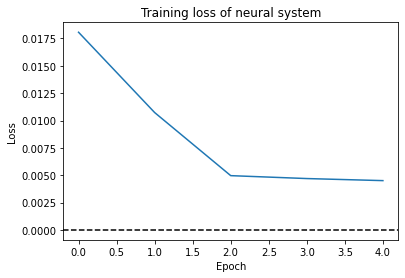

In [7]:
loss_neuralsystem = train_neuralsystem(num_steps, x_environment_init_grid,
                                       environment, neuralsystem,
                                       objective_function_mx)

plot_training_curve(loss_neuralsystem, 'Training loss of neural system')


### Evaluation

In [8]:
def evaluate_neuralsystem(
        num_steps: int,
        x_init: Tuple[float, float],
        environment: RNN,
        neuralsystem: RNN,
        objective_function: Callable[[np.ndarray, np.ndarray], np.ndarray]) \
        -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Test performance of neural system as controller.

    Parameters
    ----------
    num_steps
        How many steps to take in environment during one episode.
    x_init
        Initial states of environment.
    environment
        The environment to be controlled.
    neuralsystem
        The controller.
    objective_function
        The LQR cost function used as evaluation metric.

    Returns
    -------
        Three arrays containing (for each time step):
            - Environment states
            - Environment input (controls)
            - Costs
    """
    states = []
    controls = []
    costs = []

    # Initial states.
    x_environment = np.array(x_init)
    x_neuralsystem = neuralsystem.get_state_init(asnumpy=True)
    y_environment = x_environment

    for n in range(num_steps):
        # Compute control.
        y_neuralsystem, x_neuralsystem = neuralsystem.forward_np(
            y_environment, x_neuralsystem)

        # Compute lqr cost.
        cost = objective_function(x_environment, y_neuralsystem)

        # Take a step in environment.
        y_environment, x_environment = environment.forward_np(
            y_neuralsystem, x_environment)

        states.append(x_environment)
        controls.append(y_neuralsystem)
        costs.append(cost)

    return np.array(states), np.array(controls), np.array(costs)


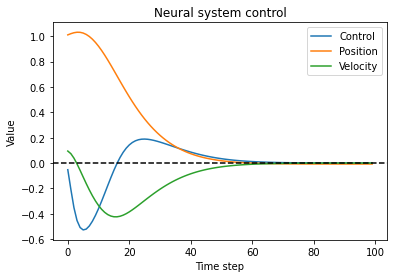

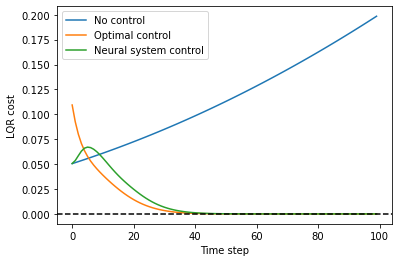

In [9]:
states_neuralsystem, controls_neuralsystem, costs_neuralsystem = \
    evaluate_neuralsystem(num_steps, x_environment_init, environment,
                          neuralsystem, objective_function)

# Show results.
plot_variables({'Control': controls_neuralsystem,
                'Position': states_neuralsystem[:, 0],
                'Velocity': states_neuralsystem[:, 1]},
               'Neural system control')

plot_metrics({'No control': costs_uncontrolled,
              'Optimal control': costs_optimal,
              'Neural system control': costs_neuralsystem})


## 3. Prosthesis (4 points)
Now that we have a functional brain model, we can perturb it and try to restore its functionality by adding a prosthesis.
- **Implement a perturbation of the neural system**, e.g. by setting some rows of the sensory synapses to zero. (Use a perturbation strength that makes the performance degrade notably, but not destroy it completely, e.g. lesion 80% of the sensory synapses.) Evaluate the perturbed neural system and compare against the results above.
- **Create a prosthesis RNN.** (Hint: A hidden population of about 40 neurons works well.)
- **Train the prosthesis** by connecting it to the association population and minimizing the objective function as before. (Hint: Create a new function "train_prosthesis" based on "train_neuralsystem" above.) Remember to freeze the neural system parameters before training the prosthesis.
- **Verify that the performance is restored.** (Hint: Create a new function "evaluate_prosthesis" based on the "evaluate_neuralsystem" function you implemented above.)
- Optional: Play around with different kinds of perturbation / prostheses models / learning rules (e.g. RL).

### Define and apply perturbation

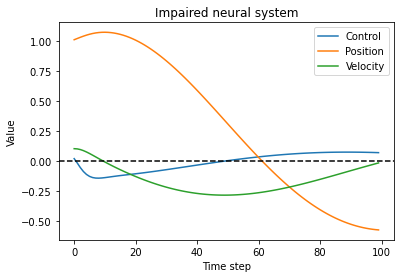

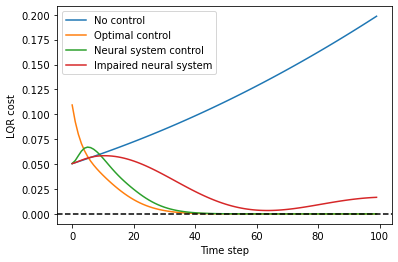

In [10]:
def perturb_neuralsystem(system: RNN):
    sensor_synapses = system.B
    sensor_synapses[:40] = 0
    system.B = sensor_synapses

# Apply some perturbation to the neural system.
perturb_neuralsystem(neuralsystem)

# Freeze weights of neural system (only prosthesis is adapted).
neuralsystem.freeze_weights()

# Test performance of impaired neural system.
states_impaired, controls_impaired, costs_impaired = evaluate_neuralsystem(
    num_steps, x_environment_init, environment, neuralsystem,
    objective_function)

# Show results.
plot_variables({'Control': controls_impaired,
                'Position': states_impaired[:, 0],
                'Velocity': states_impaired[:, 1]},
               'Impaired neural system')

plot_metrics({'No control': costs_uncontrolled,
              'Optimal control': costs_optimal,
              'Neural system control': costs_neuralsystem,
              'Impaired neural system': costs_impaired})


 ### Setup prosthesis

In [11]:
num_inputs_prosthesis = num_states_neuralsystem  # Neural recordings.
num_states_prosthesis = 40  # Hidden layer of RNN.
num_outputs_prosthesis = num_states_neuralsystem  # Stimulation signals.

prosthesis = RNN(num_inputs=num_inputs_prosthesis,
                 num_hidden=num_states_prosthesis,
                 num_outputs=num_outputs_prosthesis,
                 activation_rnn='tanh', activation_decoder='tanh')


### Training

In [12]:
def train_prosthesis(
        num_steps: int,
        x_init: np.ndarray,
        environment: RNN,
        neuralsystem: RNN,
        prosthesis: RNN,
        objective_function: Callable[[NDArray, NDArray], NDArray]) \
        -> np.ndarray:
    """Train the prosthesis by minimizing an objective function.

    Parameters
    ----------
    num_steps
        How many steps to take in environment during one episode.
    x_init
        Initial states of environment. Shape [num_samples, num_states].
    environment
        The environment.
    neuralsystem
        The perturbed neural system. Parameters should be frozen.
    prosthesis
        The controller for the neural system. Contains learnable parameters.
    objective_function
        The loss function to optimize. Must be compatible with mxnet arrays.

    Returns
    -------
        1D array with average loss values for each epoch.
    """
    learning_rate = 1e-3
    num_epochs = 5
    trainer = mx.gluon.Trainer(prosthesis.collect_params(), 'adam',
                               {'learning_rate': learning_rate})
    loss_training = []
    for _ in trange(num_epochs, desc='epoch'):
        loss_epoch = []
        for x_environment in x_init:
            x_neuralsystem = neuralsystem.get_state_init()
            x_prosthesis = prosthesis.get_state_init()
            y_environment = x_environment
            loss_sample = []
            with autograd.record():
                for n in range(num_steps):
                    # Compute stimulation signal from prosthesis.
                    y_prosthesis, x_prosthesis = prosthesis.forward(
                        x_neuralsystem, x_prosthesis)

                    # Apply stimulation signal to association population.
                    x_neuralsystem = x_neuralsystem + y_prosthesis

                    # Compute control.
                    y_neuralsystem, x_neuralsystem = neuralsystem.forward(
                        y_environment, x_neuralsystem)

                    # Compute lqr cost.
                    loss_sample.append(objective_function(x_environment,
                                                          y_neuralsystem))

                    # Take a step in environment.
                    y_environment, x_environment = environment.forward(
                        y_neuralsystem, x_environment)

                loss_sample_mean = mx.nd.mean(mx.nd.concat(*loss_sample,
                                                           dim=0))
            loss_sample_mean.backward()
            trainer.step(1)
            loss_epoch.append(loss_sample_mean.asscalar())

        loss_training.append(np.mean(loss_epoch))

    return np.array(loss_training)


epoch: 100%|██████████| 5/5 [01:39<00:00, 19.86s/it]


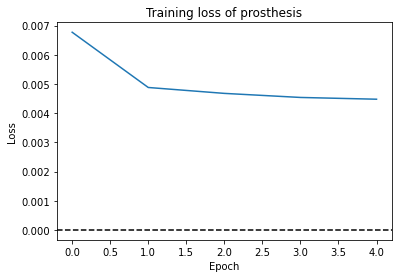

In [13]:
loss_prosthesis = train_prosthesis(num_steps, x_environment_init_grid,
                                   environment, neuralsystem, prosthesis,
                                   objective_function_mx)

plot_training_curve(loss_prosthesis, 'Training loss of prosthesis')


### Evaluation

In [14]:
def evaluate_prosthesis(
        num_steps: int,
        x_init: Tuple[float, float],
        environment: RNN,
        neuralsystem: RNN,
        prosthesis: RNN,
        objective_function: Callable[[np.ndarray, np.ndarray], np.ndarray]) \
        -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Test performance of system with prosthesis in the loop.

    Parameters
    ----------
    num_steps
        How many steps to take in environment during one episode.
    x_init
        Initial states of environment.
    environment
        The environment.
    neuralsystem
        The perturbed neural system.
    prosthesis
        The controller for the neural system.
    objective_function
        The LQR cost function used as evaluation metric.

    Returns
    -------
        Three arrays containing (for each time step):
            - Environment states
            - Environment input (controls)
            - Costs
    """
    states = []
    controls = []
    costs = []

    # Initial states.
    x_environment = np.array(x_init)
    x_neuralsystem = neuralsystem.get_state_init(asnumpy=True)
    x_prosthesis = prosthesis.get_state_init(asnumpy=True)
    y_environment = x_environment

    for n in range(num_steps):
        # Compute stimulation signal from prosthesis.
        y_prosthesis, x_prosthesis = prosthesis.forward_np(x_neuralsystem,
                                                           x_prosthesis)

        # Apply stimulation signal to association population.
        x_neuralsystem = x_neuralsystem + y_prosthesis

        # Compute control.
        y_neuralsystem, x_neuralsystem = neuralsystem.forward_np(
            y_environment, x_neuralsystem)

        # Compute lqr cost.
        cost = objective_function(x_environment, y_neuralsystem)

        # Take a step in environment.
        y_environment, x_environment = environment.forward_np(
            y_neuralsystem, x_environment)

        states.append(x_environment)
        controls.append(y_neuralsystem)
        costs.append(cost)

    return np.array(states), np.array(controls), np.array(costs)


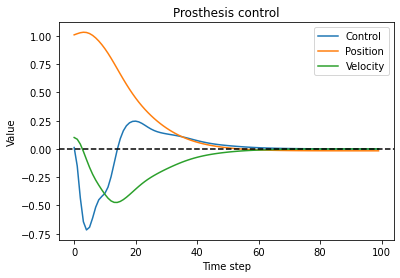

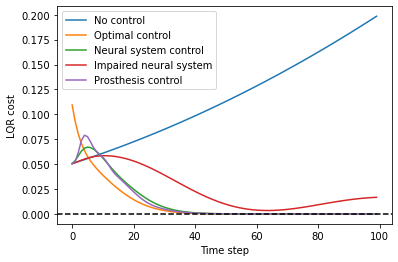

In [15]:
# Test performance of full system.
states_prosthesis, controls_prosthesis, costs_prosthesis = \
    evaluate_prosthesis(num_steps, x_environment_init, environment,
                        neuralsystem, prosthesis, objective_function)

# Show results.
plot_variables({'Control': controls_prosthesis,
                'Position': states_prosthesis[:, 0],
                'Velocity': states_prosthesis[:, 1]},
               'Prosthesis control')

plot_metrics({'No control': costs_uncontrolled,
              'Optimal control': costs_optimal,
              'Neural system control': costs_neuralsystem,
              'Impaired neural system': costs_impaired,
              'Prosthesis control': costs_prosthesis})
